In [1]:
using JuMP
using CSV
using LinearAlgebra
using DataFrames
using BARON
using Plots

In [2]:
A_db = CSV.File("./data/A_mat.csv",header=1,delim=",") |> DataFrame
B_db = CSV.File("./data/B_mat.csv",header=1,delim=",") |> DataFrame
f_db = CSV.File("./data/f_val.csv",header=1,delim=",") |> DataFrame
f_val=f_db[!,2]
A_mat=Matrix(A_db[:,2:size(A_db,2)])
B_mat=Matrix(B_db[:,2:size(B_db,2)])
nodes_val=names(A_db)[2:size(A_db,2)]
product_val=A_db[!,1]
intv_val=B_db[!,1]

9-element Vector{String31}:
 "Coal"
 "Natural Gas"
 "Waste"
 "Environment"
 "Oil"
 "Limestone "
 "Coal Energy"
 "NG Energy"
 "Environment Energy"

In [3]:
B_db

,Column1,Syngas Production,Methanol Manufacture,Steam Cracker,Hydrodealkylation (THD)
,String31,Float64,Float64,Float64,Float64
1,Coal,-55.6882,-25.4601,0.0,0.0
2,Natural Gas,-52.8947,-24.0426,-62.8951,0.0
3,Waste,20.7175,11.981,15.6427,0.251672
4,Environment,31.7886,13.2328,0.0,0.942308
5,Oil,0.0,-6.29662,-241.801,0.0
6,Limestone,0.0,0.0,0.0,0.0
7,Coal Energy,-59.4291,-18.6662,-59.11,-0.584625
8,NG Energy,-31.7968,-9.98711,-31.62,-0.312796
9,Environment Energy,91.2258,28.6533,90.73,0.897421


In [4]:
function opt_decarb_base()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb, 1 ≥ s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj)
end
    

opt_decarb_base (generic function with 1 method)

In [5]:
function opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end
    

opt_decarb_em (generic function with 1 method)

In [6]:
function opt_decarb_ruse()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==-1*(sum(g[k] for k in 1:2)+sum(g[5:8])))
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end

opt_decarb_ruse (generic function with 1 method)

In [7]:
function opt_decarb_eps(lb,ub,ep)
    dcrb =  Model(BARON.Optimizer)
    set_optimizer_attribute(dcrb,"PrLevel",0)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,-1*(sum(g[k] for k in 1:2)+sum(g[5:8])) ≤ lb+(ub-lb)*ep)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end

opt_decarb_eps (generic function with 1 method)

In [8]:
s,f,obj_em,g_em=opt_decarb_em()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Solving bounding LP
 Preprocessing found feasible solution with value  674.793769393     
 Problem solved during preprocessing
 Lower bound is  674.793769393     

 Calculating duals

                         *** Normal completion ***            

 Wall clock time:                     0.02
 Total CPU time used:             

([0.9999999999999032, 1.0, 1.0090556646688351, 0.9362144182838755, 1.0695784630053495, 1.9580893215458828, 0.0, 1.958089321545883, 1.0, 1.0  …  1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0], [25.891018048, 40.254667052, 0.754126315000008, 42.891233347, 10.572503059, 13.331253301092943, 0.0, 12.02323806009816, 0.0, 43.6  …  14.67692308, 6.520258063, 9.33513253, 41.93128333, 6.951724138000001, 19.965538247645146, 7.2, 8.346, 1.9232876710000002, 209.1198411], 674.7937693931248, [-81.14824449997654, -146.41356101952977, 79.87458102267179, 45.90356892769774, -583.3512396536385, 0.0, -361.8786603892484, -187.13695904250676, 549.0156194427552])

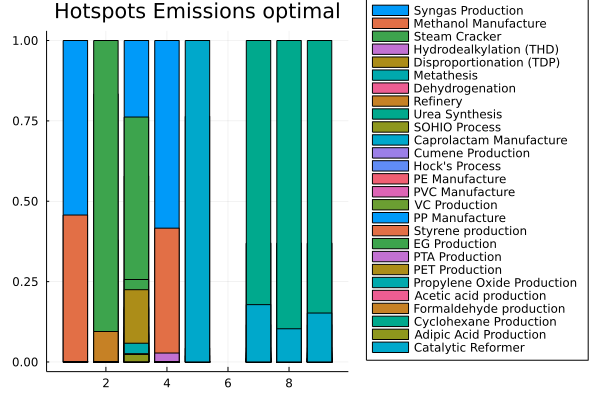

In [9]:
leg=reshape(nodes_val, 1,length(nodes_val))
htspts=abs.(B_mat.*s')
htspts=htspts./ maximum.(eachrow(htspts))
#delete!(htspts, 6)
bar(htspts,label=leg,legend=:outerbottomright,title="Hotspots Emissions optimal")

In [10]:
s,f,obj_ru,g_ru=opt_decarb_ruse()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Solving bounding LP
 Preprocessing found feasible solution with value  1348.33499791     
 Problem solved during preprocessing
 Lower bound is  1348.33499791     

 Calculating duals

                         *** Normal completion ***            

 Wall clock time:                     0.00
 Total CPU time used:             

([0.9999999999999032, 1.0, 1.0, 1.0000000000000013, 0.9999999999999991, 1.0000000000000029, 1.000000000000003, 1.000000000000003, 1.0, 1.0  …  1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0], [25.891018048, 40.254667052, 0.754126315000008, 42.891233347, 10.572503059, 12.947543133000002, 0.0, 0.0, 0.0, 43.6  …  14.67692308, 6.520258063, 9.33513253, 41.93128333, 6.951724138000001, 19.78635961, 7.2, 8.346, 1.9232876710000002, 209.1198411], 1348.3349979129207, [-81.14824449997656, -142.9025301049778, 80.00937935298786, 45.96367457198753, -574.4710476749951, 0.0, -362.398192530981, -187.41498310198986, 549.8131756439709])

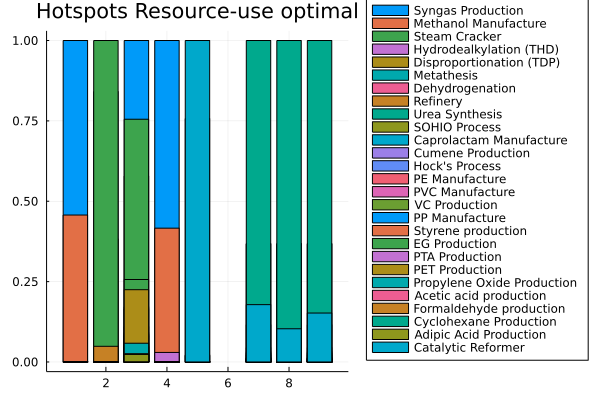

In [11]:
leg=reshape(nodes_val, 1,length(nodes_val))
htspts=abs.(B_mat.*s')
htspts=htspts./ maximum.(eachrow(htspts))
#delete!(htspts, 6)
bar(htspts,label=leg,legend=:outerbottomright,title="Hotspots Resource-use optimal")

In [12]:
res_f=DataFrame(pdt=product_val, final_demand=f)
res_s=DataFrame(node=nodes_val, scaling_factor=s)

,node,scaling_factor
,String,Float64
1,Syngas Production,1.0
2,Methanol Manufacture,1.0
3,Steam Cracker,1.0
4,Hydrodealkylation (THD),1.0
5,Disproportionation (TDP),1.0
6,Metathesis,1.0
7,Dehydrogenation,1.0
8,Refinery,1.0
9,Urea Synthesis,1.0


In [13]:
ub_em=(sum(g_ru[3:4])+sum(g_ru[9:9]))
ub=-1*(sum(g_em[1:2])+sum(g_em[5:8]))
lb=obj_ru

e_vec=[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
eps_res=DataFrame(Emissions=[obj_em,ub_em], Resource_Use=[ub,lb])
for i in 1:size(e_vec,2)
    s,f,obj_eps,g_eps=opt_decarb_eps(lb,ub,e_vec[i])
    temp_ru=-1*(sum(g_eps[1:2])+sum(g_eps[5:8]))
    #eps_res=eps_res.append({'Emissions':obj_eps,'Resource_Use':temp_ru})
    push!(eps_res,[obj_eps, temp_ru])
end
eps_res

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX lib

,Emissions,Resource_Use
,Float64,Float64
1,674.794,1359.93
2,675.786,1348.33
3,675.687,1349.49
4,675.588,1350.65
5,675.488,1351.81
6,675.389,1352.97
7,675.29,1354.13
8,675.191,1355.29
9,675.092,1356.45


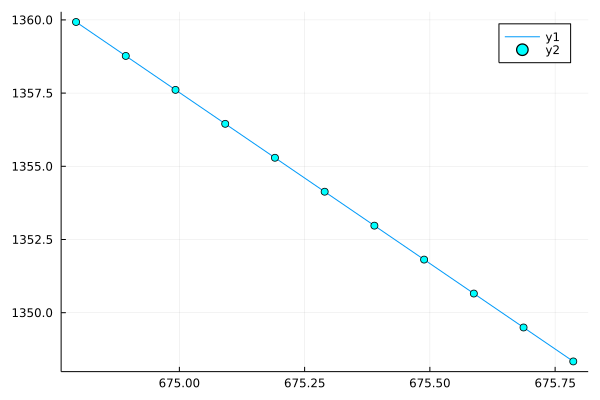

In [14]:
sort!(eps_res,:Emissions)
plot(eps_res[!,:Emissions],eps_res[!,:Resource_Use])
plot!(eps_res[!,:Emissions],eps_res[!,:Resource_Use], seriestype = :scatter, color="cyan")

In [15]:
eps_res

,Emissions,Resource_Use
,Float64,Float64
1,674.794,1359.93
2,674.893,1358.77
3,674.992,1357.61
4,675.092,1356.45
5,675.191,1355.29
6,675.29,1354.13
7,675.389,1352.97
8,675.488,1351.81
9,675.588,1350.65


## Sensitivity optimization

In [16]:
function sens_opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_em (generic function with 1 method)

In [17]:
function sens_opt_decarb_ru()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==-1*(sum(g[k] for k in 1:2)+sum(g[5:8])))
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_ru (generic function with 1 method)

In [18]:
function sens_opt_decarb_eps(lb,ub,ep)
    dcrb =  Model(BARON.Optimizer)
    set_optimizer_attribute(dcrb,"PrLevel",0)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,-1*(sum(g[k] for k in 1:2)+sum(g[5:8])) ≤ lb+(ub-lb)*ep)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_eps (generic function with 1 method)

In [19]:
s,f,obj_em,g_em,y1,y2=sens_opt_decarb_em()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  600.318176218     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             1.86

([0.7526016289435181, 0.8879841577540106, 0.9113257882135315, 1.606115987916795, 0.3465715670482334, 3.057922229234248, 0.0, 3.057922229234244, 0.9090909090909092, 1.0  …  1.0, 0.8597492981087163, 0.9274340909092365, 0.9090909090909091, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.00192869860631], [25.891018048, 40.254667052, 0.754126315000008, 42.891233347, 10.572503059, 12.947543133, 0.0, 18.776532064596044, 0.0, 43.6  …  14.67692308, 6.520258063, 9.33513253, 41.93128333, 6.951724138, 19.8350017442056, 7.2, 8.346, 1.923287671, 209.52317024608135], 598.45570485498, [-64.51914813519942, -127.86426974387184, 71.11094156793646, 37.18809524202562, -567.3110358997134, 0.0, -323.54275221932807, -166.61391581559266, 490.15666804501797], [0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [20]:
print(" Positive perturbations \n\n")

for i in 1:size(findall(x->x==1, y1),1)
    print(nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n")
end   
print("\n Negative perturbations \n\n")
for i in 1:size(findall(x->x==1, y2),1)
    print(nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n")
end   

 Positive perturbations 

Syngas Production ---- Syngas
Methanol Manufacture ---- Methanol 
Steam Cracker ---- Ethylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
EG Production ---- Ethylene glycol 
PET Production ---- Polyethylene Terephthalate (PET)

 Negative perturbations 

Methanol Manufacture ---- Syngas
Urea Synthesis ---- Syngas
Formaldehyde production ---- Methanol 


In [21]:

per_em=""
for i in 1:size(findall(x->x==1, y1),1)
    pos_em=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
    per_em=per_em*pos_em
end   
per_em=per_em*"\n\n"
for i in 1:size(findall(x->x==1, y2),1)
    neg_em=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
    per_em=per_em*neg_em
end  
per_em=replace(per_em,"\n"=>" | ")
print("\n")

In [22]:
s,f,obj_ru,g_ru,y1,y2=sens_opt_decarb_ru()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  1271.33377025     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             2.23

([0.766257817873317, 0.9090909090909091, 0.9131669527684223, 1.9466870238611387, 0.05583963216006433, 1.4743699629825957, 1.4743699629825957, 1.4743699629825957, 0.9090909090909092, 1.0  …  1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9120689029035804], [25.891018048, 40.254667052, 0.7541263150000079, 42.891233347, 10.572503058999999, 12.947543133, 0.0, 0.0, 0.0, 43.6  …  14.67692308, 6.520258062999999, 9.33513253, 41.93128333, 6.951724138, 19.87507468258828, 7.2, 8.346, 1.923287671, 209.80487445219288], 1211.8116696918655, [-65.81701565009274, -124.3481344367868, 73.40324359624506, 38.22242981270875, -528.1305915398123, 0.0, -325.35207548878975, -168.16385257638385, 493.5159280754463], [0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.9999999999999999], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [23]:
print(" Positive perturbations \n\n")
per_ru=""
for i in 1:size(findall(x->x==1, y1),1)
    pos_ru=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
    print(pos_ru)
    per_ru=per_ru*pos_ru
end   
print("\n\n Negative perturbations \n\n")
per_ru=per_ru*"\n\n"
for i in 1:size(findall(x->x==1, y2),1)
    neg_ru=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
    print(neg_ru)
    per_ru=per_ru*neg_ru
end  
per_ru=replace(per_ru,"\n"=>" | ")
print("\n")

 Positive perturbations 

Syngas Production ---- Syngas
Methanol Manufacture ---- Methanol 
Steam Cracker ---- Ethylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
Catalytic Reformer ---- Toluene 


 Negative perturbations 

Urea Synthesis ---- Syngas
PTA Production ---- Xylene 



In [24]:
function get_per_str(y1,y2)
    per_em=""
    for i in 1:size(findall(x->x==1, y1),1)
        pos_em=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
        per_em=per_em*pos_em
    end   
    per_em=per_em*"\n\n"
    for i in 1:size(findall(x->x==1, y2),1)
        neg_em=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
        per_em=per_em*neg_em
    end  
    per_em=replace(per_em,"\n"=>" | ")
    print("\n")
    return per_em
end


get_per_str (generic function with 1 method)

In [25]:
ub_em=(sum(g_ru[3:4])+sum(g_ru[9:9]))
ub=-1*(sum(g_em[1:2])+sum(g_em[5:8]))
lb=obj_ru

e_vec=[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
eps_res_sens=DataFrame(Emissions=[obj_em,ub_em], Resource_Use=[ub,lb], Perturbations=[per_em,per_ru])
for i in 1:size(e_vec,2)
    s,f,obj_eps,g_eps,y1,y2=sens_opt_decarb_eps(lb,ub,e_vec[i])
    temp_ru=-1*(sum(g_eps[1:2])+sum(g_eps[5:8]))
    #eps_res=eps_res.append({'Emissions':obj_eps,'Resource_Use':temp_ru})
    push!(eps_res_sens,[obj_eps, temp_ru,get_per_str(y1,y2)])
end

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX

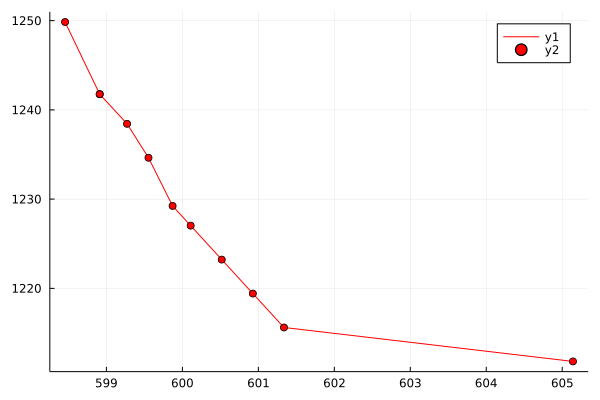

In [26]:
sort!(eps_res_sens,:Emissions)
plot(eps_res_sens[!,:Emissions],eps_res_sens[!,:Resource_Use],color="red")
plot!(eps_res_sens[!,:Emissions],eps_res_sens[!,:Resource_Use], seriestype = :scatter, color="red")

In [27]:
eps_res_sens

,Emissions,Resource_Use,Perturbations
,Float64,Float64,String
1,598.456,1249.85,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | EG Production ---- Ethylene glycol | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
2,598.912,1241.76,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas |
3,598.912,1241.76,Syngas Production ---- Syngas | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PET Production ---- Polyethylene Terephthalate (PET) | | | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
4,599.272,1238.44,Syngas Production ---- Syngas | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
5,599.554,1234.64,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Propylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas |
6,599.871,1229.24,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
7,600.109,1227.03,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
8,600.518,1223.22,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
9,600.928,1219.42,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |


In [28]:
function sens_opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,0 ≤ y1b[k=1:size(B_mat,1),j=1:size(B_mat,2)]≤ 0.1)
    @variable(dcrb,0 ≤ y2b[k=1:size(B_mat,1),j=1:size(B_mat,2)]≤ 0.1)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,0 ≤ yb[k=1:size(B_mat,1),j=1:size(B_mat,2)] ≤ 0.2)
    
    
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,[k=1:size(B_mat,1),j=1:size(A_mat,2)],yb[k,j] == y1b[k,j]+y2b[k,j])
    
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) +
        sum(yb[k,j] for k in 1:size(B_mat,1), j=1:size(B_mat,2))*10 ≤ 10)
    
    @constraint(dcrb,[j=1:size(A_mat,2)],-0.001 ≤ sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j]) for i in 1:size(A_mat,1))+
        sum(B_mat[k,j]*(1+0.1*y1b[k,j]-0.1*y2b[k,j]) for k in 1:5)≤ 0.001)
    
    @constraint(dcrb,[j=1:5,7:11,14:23,27],-0.001 ≤ sum((1+0.1*y1b[k,j]-0.1*y2b[k,j])*B_mat[k,j] for k in 7:9)≤ 0.001)
    
    @constraint(dcrb,[j=1:5,7:11,14:23,27],y1b)
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*(1+0.1*y1b[k,j]-0.1*y2b[k,j])*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    
    
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2),JuMP.value.(y1b),JuMP.value.(y2b)
end
    

LoadError: LoadError: type Symbol has no field head
in expression starting at In[28]:27

In [29]:
s,f,obj_em,g_em,y1,y2,y1b,y2b=sens_opt_decarb_em()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  600.318176218     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             1.88

LoadError: BoundsError: attempt to access Tuple{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Matrix{Float64}, Matrix{Float64}} at index [7]

In [30]:
sum(y2b)

LoadError: UndefVarError: y2b not defined

In [31]:
print(" Positive perturbations \n\n")

for i in 1:size(findall(x->x==1, y1),1)
    print(nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n")
end   
print("\n Negative perturbations \n\n")
for i in 1:size(findall(x->x==1, y2),1)
    print(nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n")
end   

 Positive perturbations 

Syngas Production ---- Syngas
Methanol Manufacture ---- Methanol 
Steam Cracker ---- Ethylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
EG Production ---- Ethylene glycol 
PET Production ---- Polyethylene Terephthalate (PET)

 Negative perturbations 

Methanol Manufacture ---- Syngas
Urea Synthesis ---- Syngas
Formaldehyde production ---- Methanol 


In [32]:
print(" Positive perturbations \n\n")

for i in 1:size(findall(x->x>0, y1b),1)
    print(nodes_val[findall(x->x>0, y1b)[i][2]]*" ---- "*intv_val[findall(x->x>0, y1b)[i][1]]*"\n")
end   
print("\n Negative perturbations \n\n")
for i in 1:size(findall(x->x>0, y2b),1)
    print(nodes_val[findall(x->x>0, y2b)[i][2]]*" ---- "*intv_val[findall(x->x>0, y2b)[i][1]]*"\n")
end   

 Positive perturbations 



LoadError: UndefVarError: y1b not defined

In [33]:
y2b

LoadError: UndefVarError: y2b not defined

In [34]:
B_db

,Column1,Syngas Production,Methanol Manufacture,Steam Cracker,Hydrodealkylation (THD)
,String31,Float64,Float64,Float64,Float64
1,Coal,-55.6882,-25.4601,0.0,0.0
2,Natural Gas,-52.8947,-24.0426,-62.8951,0.0
3,Waste,20.7175,11.981,15.6427,0.251672
4,Environment,31.7886,13.2328,0.0,0.942308
5,Oil,0.0,-6.29662,-241.801,0.0
6,Limestone,0.0,0.0,0.0,0.0
7,Coal Energy,-59.4291,-18.6662,-59.11,-0.584625
8,NG Energy,-31.7968,-9.98711,-31.62,-0.312796
9,Environment Energy,91.2258,28.6533,90.73,0.897421


In [35]:
A_db

,Column1,Syngas Production,Methanol Manufacture,Steam Cracker
,String63,Float64,Float64,Float64
1,Methanol,0.0,38.25,0.0
2,Ethylene,0.0,0.0,177.429
3,Propylene,0.0,0.0,57.8767
4,Toluene,0.0,0.0,11.2076
5,Benzene,0.0,0.0,17.6604
6,Xylene,0.0,0.0,5.09435
7,Butene,0.0,0.0,0.0
8,Propane,0.0,0.0,0.0
9,Syngas,56.0767,-7.66455,0.0


In [36]:
B_mat

9×27 Matrix{Float64}:
 -55.6882  -25.4601      0.0     …  0.0        0.0          0.0
 -52.8947  -24.0426    -62.8951     0.0        0.0          0.0
  20.7175   11.981      15.6427     0.0768513  0.483569     0.0
  31.7886   13.2328      0.0        0.0        0.0          0.0
   0.0      -6.29662  -241.801      0.0        0.0       -319.39
   0.0       0.0         0.0     …  0.0        0.0          0.0
 -59.4291  -18.6662    -59.11       0.0        0.0        -28.7596
 -31.7968   -9.98711   -31.62       0.0        0.0         -8.91191
  91.2258   28.6533     90.73       0.0        0.0         37.6715

In [37]:
sum(B_mat[k,27] for k in 7:9)

0.0